In [45]:
# Import Libraries
import os , sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway ,ttest_ind, ttest_rel

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


In [46]:
# Read the data
audio_data = pd.read_csv('Data/Audio_data.csv')
poster_data = pd.read_csv('Data/Poster_data.csv')
npc_data = pd.read_csv('Data/NPC_data.csv')


In [47]:
# Extract pre-scores from each dataset
audio_pre_scores = audio_data.filter(like='pre-', axis=1)
audio_pre_scores['Dataset'] = 'Audio'

npc_pre_scores = npc_data.filter(like='pre-', axis=1)
npc_pre_scores['Dataset'] = 'NPC'

poster_pre_scores = poster_data.filter(like='pre-', axis=1)
poster_pre_scores['Dataset'] = 'Poster'

# Combine the pre-scores into a single dataframe
combined_pre_scores = pd.concat([audio_pre_scores, npc_pre_scores, poster_pre_scores], axis=0)

combined_pre_scores.head()

,pre-affective,pre-cognitive,pre-connative,pre-PEB,Dataset
0,4.33,3.5,4.0,3.43,Audio
1,3.33,4.0,5.0,3.00,Audio
2,2.67,3.5,4.5,3.57,Audio
3,4.00,3.5,4.5,4.43,Audio
4,3.33,4.0,3.0,3.71,Audio


In [48]:
# Melt the dataframe
melted_pre_scores = pd.melt(combined_pre_scores, id_vars=['Dataset'], var_name='Score Type', value_name='Score')

melted_pre_scores.head()

,Dataset,Score Type,Score
0,Audio,pre-affective,4.33
1,Audio,pre-affective,3.33
2,Audio,pre-affective,2.67
3,Audio,pre-affective,4.00
4,Audio,pre-affective,3.33


## Simple Testing

### One-way anova

In [49]:
# ANOVA for each score type
score_types = melted_pre_scores['Score Type'].unique()
anova_results = {}

for score_type in score_types:
    # Filter scores by type
    scores_by_type = melted_pre_scores[melted_pre_scores['Score Type'] == score_type]
    
    # Group scores by dataset
    audio_scores = scores_by_type[scores_by_type['Dataset'] == 'Audio']['Score']
    npc_scores = scores_by_type[scores_by_type['Dataset'] == 'NPC']['Score']
    poster_scores = scores_by_type[scores_by_type['Dataset'] == 'Poster']['Score']
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(audio_scores, npc_scores, poster_scores)
    anova_results[score_type] = f_stat, p_value

anova_results

{'pre-affective': (2.0449496281121946, 0.138773081496251),
 'pre-cognitive': (1.1915037086985836, 0.31121535550073304),
 'pre-connative': (1.9793155321549467, 0.14754687907939523),
 'pre-PEB': (5.086573124445172, 0.009275903364135531)}

The ANOVA results for the pre-scores across the three datasets show the following p-values for each score type:

- Affective: p-value = 0.139, indicating no significant difference at the baseline level for affective scores across the datasets.
- Cognitive: p-value = 0.311, indicating no significant difference at the baseline level for cognitive scores across the datasets.
- Connative: p-value = 0.148, indicating no significant difference at the baseline level for connative scores across the datasets.
- Pro-Environmental Behaviour (PEB): p-value = 0.009, indicating a significant difference at the baseline level for PEB scores across the datasets.

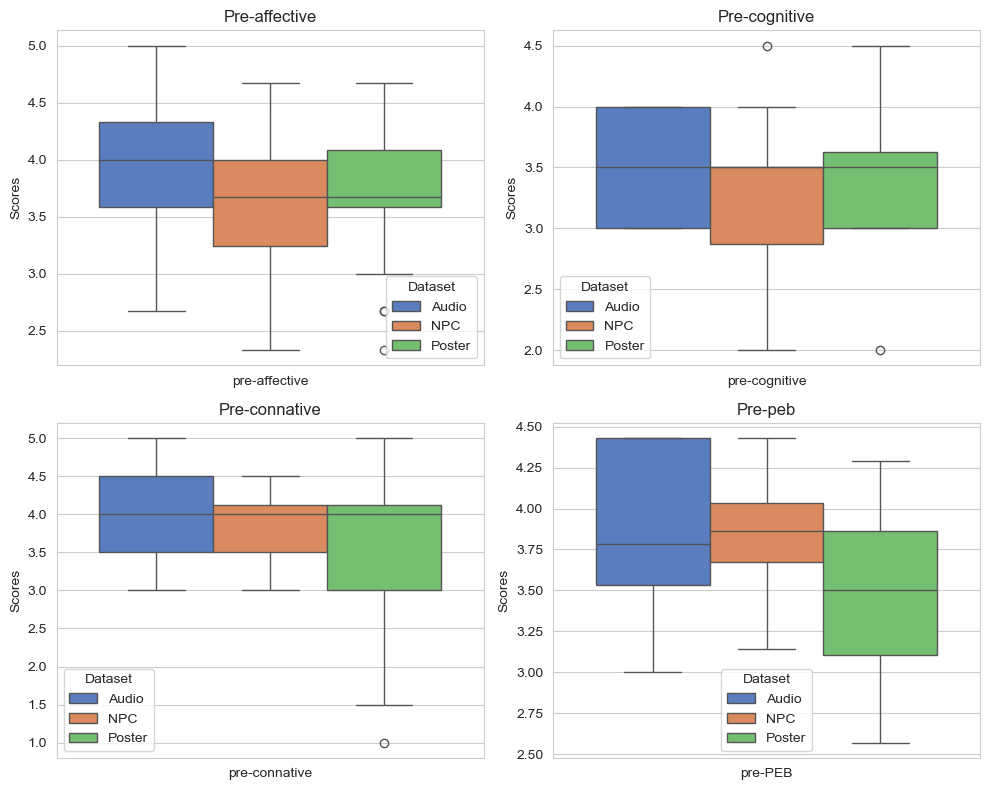

In [50]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and axes for the plots with the 'muted' palette
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot for each score type with 'muted' palette
for ax, score_type in zip(axs.flat, score_types):
    sns.boxplot(x='Score Type', y='Score', hue='Dataset', 
                data=melted_pre_scores[melted_pre_scores['Score Type'] == score_type], 
                ax=ax, palette="muted")
    ax.set_title(score_type.capitalize())
    ax.set_xlabel('')
    ax.set_ylabel('Scores')
    ax.legend(title='Dataset')

plt.tight_layout()
plt.show()



In [51]:
# Filter pre-PEB scores by dataset
pre_peb_scores = melted_pre_scores[melted_pre_scores['Score Type'] == 'pre-PEB']

# Datasets
datasets = ['Audio', 'NPC', 'Poster']

# Perform pairwise t-tests
t_test_results = {}
for i in range(len(datasets)):
    for j in range(i+1, len(datasets)):
        dataset_1, dataset_2 = datasets[i], datasets[j]
        scores_1 = pre_peb_scores[pre_peb_scores['Dataset'] == dataset_1]['Score']
        scores_2 = pre_peb_scores[pre_peb_scores['Dataset'] == dataset_2]['Score']
        
        # Perform t-test
        stat, p_value = ttest_ind(scores_1, scores_2)
        t_test_results[f'{dataset_1} vs {dataset_2}'] = p_value

t_test_results

{'Audio vs NPC': 0.8592163621855957,
 'Audio vs Poster': 0.015369913385635228,
 'NPC vs Poster': 0.008135990059950101}

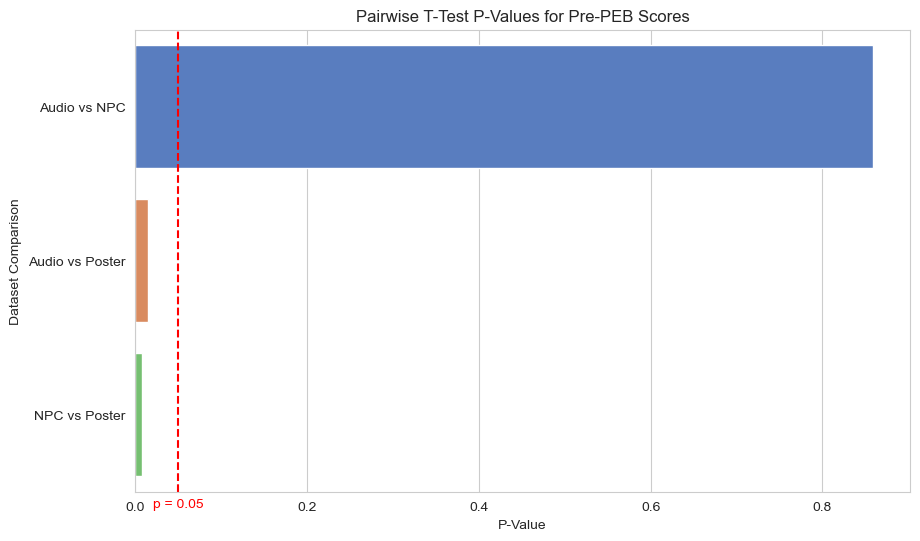

In [52]:
# Create a bar plot for the t-test results with annotation for the significance threshold
plt.figure(figsize=(10, 6))
sns.barplot(x='P-Value', y='Comparison', data=t_test_data, palette='muted')
plt.axvline(x=0.05, color='red', linestyle='--')  # Threshold for significance

# Annotate the significance threshold
plt.text(0.08, 2.6, 'p = 0.05', color='red', ha='right')

plt.title('Pairwise T-Test P-Values for Pre-PEB Scores')
plt.xlabel('P-Value')
plt.ylabel('Dataset Comparison')
plt.show()


As shown, the comparisons Audio vs Poster and NPC vs Poster have p-values below the 0.05 threshold, highlighting significant differences between these groups' pre-PEB scores. 
In contrast, the Audio vs NPC comparison is not significant, indicating no substantial difference in pre-PEB scores between these two groups.



## Data Normalization

In [53]:
from scipy.stats import zscore

# Applying Z-score normalization to the combined pre-scores
# Note: We normalize within each score type across all datasets to make them comparable
normalized_scores = melted_pre_scores.copy()

# Apply Z-score normalization for each score type separately
normalized_scores['Normalized Score'] = normalized_scores.groupby('Score Type')['Score'].transform(zscore)

# Splitting the normalized scores back into their respective datasets for further analysis
audio_normalized = normalized_scores[normalized_scores['Dataset'] == 'Audio']
npc_normalized = normalized_scores[normalized_scores['Dataset'] == 'NPC']
poster_normalized = normalized_scores[normalized_scores['Dataset'] == 'Poster']

normalized_scores.head()


,Dataset,Score Type,Score,Normalized Score
0,Audio,pre-affective,4.33,0.904720
1,Audio,pre-affective,3.33,-0.670990
2,Audio,pre-affective,2.67,-1.710959
3,Audio,pre-affective,4.00,0.384736
4,Audio,pre-affective,3.33,-0.670990


In [57]:
# Extracting pre-scores for each dataset
pre_audio_scores = audio_data.filter(like='pre-', axis=1).melt(value_name='Score')
pre_audio_scores['Dataset'] = 'Audio'

pre_npc_scores = npc_data.filter(like='pre-', axis=1).melt(value_name='Score')
pre_npc_scores['Dataset'] = 'NPC'

pre_poster_scores = poster_data.filter(like='pre-', axis=1).melt(value_name='Score')
pre_poster_scores['Dataset'] = 'Poster'

# Combining pre-scores into a single dataframe for pre-normalization visualization
combined_pre_scores_all_datasets = pd.concat([pre_audio_scores, pre_npc_scores, pre_poster_scores])

# Extracting normalized pre-scores for each dataset
norm_pre_audio_scores = audio_normalized[audio_normalized['Score Type'].str.contains('pre')]
norm_pre_npc_scores = npc_normalized[npc_normalized['Score Type'].str.contains('pre')]
norm_pre_poster_scores = poster_normalized[poster_normalized['Score Type'].str.contains('pre')]

# Combining normalized pre-scores into a single dataframe for post-normalization visualization
combined_norm_pre_scores_all_datasets = pd.concat([norm_pre_audio_scores, norm_pre_npc_scores, norm_pre_poster_scores])



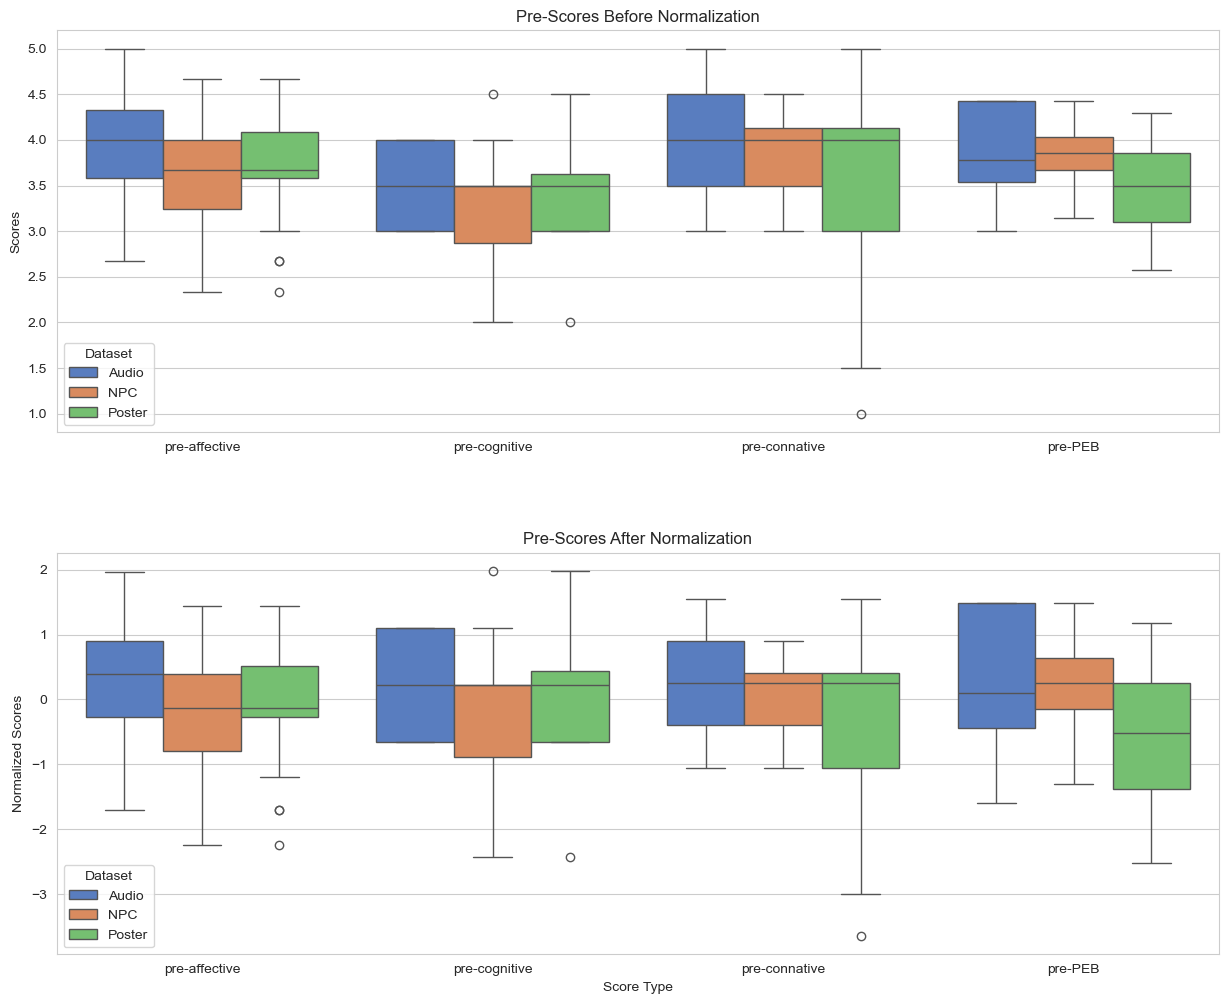

In [65]:
# Creating the figure and axes for the subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'hspace': 0.3})

# Plot pre-normalization scores
sns.boxplot(x='variable', y='Score', hue='Dataset', data=combined_pre_scores_all_datasets, ax=axs[0], palette='muted')
axs[0].set_title('Pre-Scores Before Normalization')
axs[0].set_xlabel('')
axs[0].set_ylabel('Scores')
axs[0].legend(title='Dataset')

# Plot post-normalization scores
sns.boxplot(x='Score Type', y='Normalized Score', hue='Dataset', data=combined_norm_pre_scores_all_datasets, ax=axs[1], palette='muted')
axs[1].set_title('Pre-Scores After Normalization')
axs[1].set_xlabel('Score Type')
axs[1].set_ylabel('Normalized Scores')
axs[1].legend(title='Dataset')

plt.show()


In [62]:
# Extract post-scores from each dataset
audio_post_scores = audio_data.filter(like='post-', axis=1)
audio_post_scores['Dataset'] = 'Audio'

npc_post_scores = npc_data.filter(like='post-', axis=1)
npc_post_scores['Dataset'] = 'NPC'

poster_post_scores = poster_data.filter(like='post-', axis=1)
poster_post_scores['Dataset'] = 'Poster'

# Combine the post-scores into a single dataframe
combined_post_scores = pd.concat([audio_post_scores, npc_post_scores, poster_post_scores], axis=0)

# Melt the dataframe for easier analysis and visualization
melted_post_scores = pd.melt(combined_post_scores, id_vars=['Dataset'], var_name='Score Type', value_name='Score')

# Apply Z-score normalization for each score type separately
melted_post_scores['Normalized Score'] = melted_post_scores.groupby('Score Type')['Score'].transform(zscore)



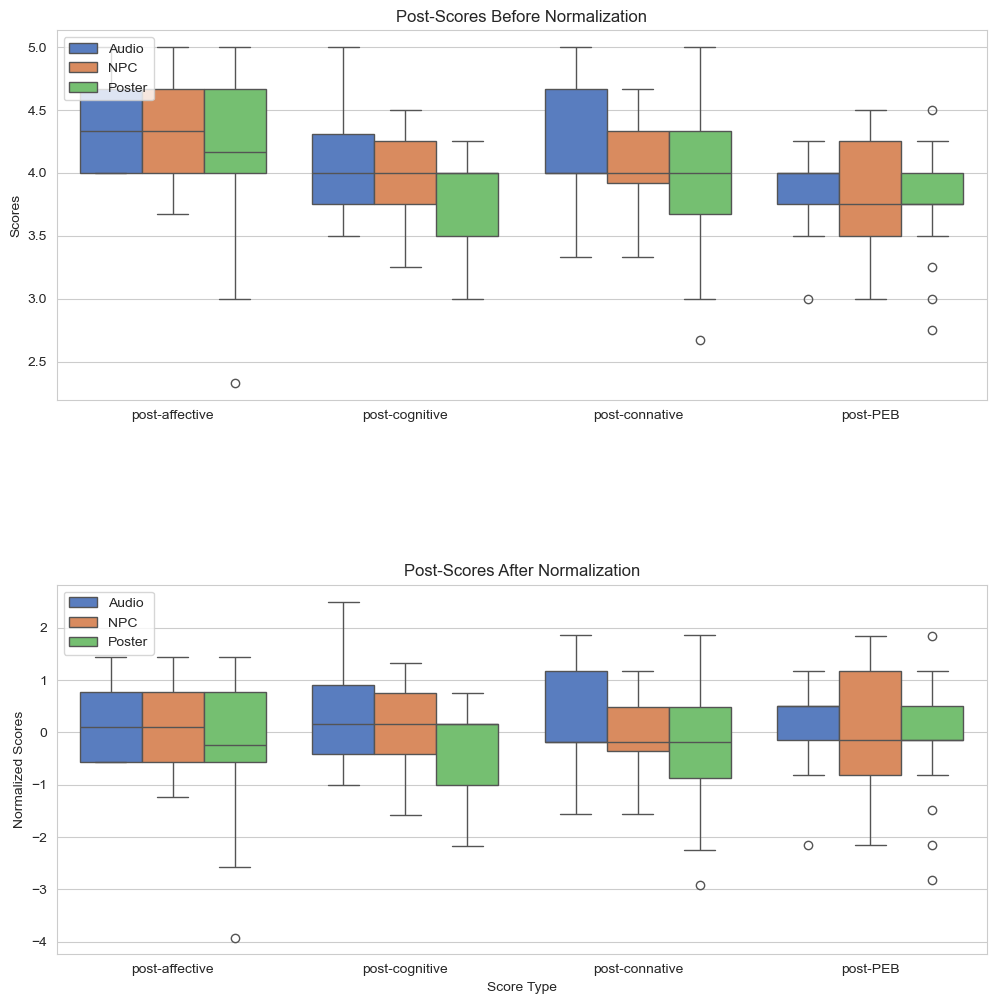

In [67]:
# Adjusting the violin plots without using the 'split' parameter
fig, axs = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'hspace': 0.5})

# Violin plot for post-scores before normalization
sns.boxplot(x='Score Type', y='Score', hue='Dataset', data=melted_post_scores, ax=axs[0], palette='muted')
axs[0].set_title('Post-Scores Before Normalization')
axs[0].set_xlabel('')
axs[0].set_ylabel('Scores')
axs[0].legend(loc='upper left')

# Violin plot for post-scores after normalization
sns.boxplot(x='Score Type', y='Normalized Score', hue='Dataset', data=melted_post_scores, ax=axs[1], palette='muted')
axs[1].set_title('Post-Scores After Normalization')
axs[1].set_xlabel('Score Type')
axs[1].set_ylabel('Normalized Scores')
axs[1].legend(loc='upper left')

plt.show()
